# 投球分類モデル（Deep Dive改善版）: 階層的分類モデル (Hierarchical Classification)
**作成日**: 2026/01/13
**目的**: SI vs FF, FC vs SL の誤分類（物理的重複）を解決するため、2段階の階層的モデルを構築する。
1.  **Macro Model**: 大枠の球種グループ（Fastball, Breaking, Offspeed）に分類。
2.  **Micro Model (Specialized)**:
    *   **SI/FF**: 球速 (`release_speed`) を特徴量から**除外**し、純粋な変化と回転のみで判定させる。
    *   **FC/SL**: 判定困難な領域に特化したモデルで判定させる。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'sans-serif'


In [2]:
# データの読み込み
df = pd.read_csv('train_with_features.csv')
print(f"Data shape: {df.shape}")

# === Feature Engineering (Re-creating needed features) ===
# 1. velocity_times_pfx_z (FS/CH interaction)
df['velocity_times_pfx_z'] = df['release_speed'] * df['pfx_z']

# 2. spin_per_mph
df['spin_per_mph'] = df['release_spin_rate'] / df['release_speed']

# 3. horizontal_vertical_ratio (SI/FF interaction) - NEW for Hierarchical
df['horizontal_vertical_ratio'] = df['pfx_x'] / (df['pfx_z'].abs() + 0.1)

# 4. speed_spin_ratio
df['speed_spin_ratio'] = df['release_speed'] / (df['release_spin_rate'] + 1)

# 必要な特徴量の定義
features_base = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z', 'movement_magnitude', 
    'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis',
    'speed_spin_ratio', 'horizontal_vertical_ratio'
]
target = 'pitch_type'

# 欠損値処理（最低限）
# Ensure columns exist before dropna
missing_cols = [c for c in features_base if c not in df.columns]
if missing_cols:
    print(f"Warning: Still missing cols: {missing_cols}")

df_clean = df.dropna(subset=features_base + [target]).copy()
print(f"Clean data shape: {df_clean.shape}")


Data shape: (495454, 20)
Clean data shape: (495454, 22)


In [3]:
# === Stage 1: Macro Model Preparation ===

# グループ定義
# Fastball: FF, SI
# Breaking: SL, FC, CUT, ST, CU, KC, EP, SV, KN
# Offspeed: FS, CH, FO

def get_macro_label(pitch_type):
    if pitch_type in ['FF', 'SI']:
        return 'Fastball'
    elif pitch_type in ['SL', 'FC', 'CUT', 'ST', 'CU', 'KC', 'EP', 'SV', 'KN']:
        return 'Breaking'
    elif pitch_type in ['FS', 'CH', 'FO']:
        return 'Offspeed'
    else:
        return 'Other'

df_clean['macro_label'] = df_clean['pitch_type'].apply(get_macro_label)
df_clean = df_clean[df_clean['macro_label'] != 'Other']

print("Macro Label Distribution:")
print(df_clean['macro_label'].value_counts())

le_macro = LabelEncoder()
y_macro = le_macro.fit_transform(df_clean['macro_label'])
X_macro = df_clean[features_base]

# Split
X_train_macro, X_valid_macro, y_train_macro, y_valid_macro, idx_train, idx_valid = train_test_split(
    X_macro, y_macro, df_clean.index, test_size=0.2, random_state=42, stratify=y_macro
)


Macro Label Distribution:
macro_label
Fastball    235710
Breaking    193374
Offspeed     65459
Name: count, dtype: int64


In [4]:
# === Stage 1: Train Macro Model ===
# XGBoostを使用

# クラス重みの計算（不均衡データ用）
from sklearn.utils.class_weight import compute_sample_weight
sample_weights_macro = compute_sample_weight(
    class_weight='balanced',
    y=y_train_macro
)

model_macro = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)

model_macro.fit(X_train_macro, y_train_macro, sample_weight=sample_weights_macro)

# Evaluate
y_pred_macro = model_macro.predict(X_valid_macro)
print("Macro Model Accuracy:", accuracy_score(y_valid_macro, y_pred_macro))
print(classification_report(y_valid_macro, y_pred_macro, target_names=le_macro.classes_))


Macro Model Accuracy: 0.976068911828044
              precision    recall  f1-score   support

    Breaking       0.99      0.98      0.99     38675
    Fastball       0.98      0.97      0.98     47142
    Offspeed       0.92      0.98      0.95     13092

    accuracy                           0.98     98909
   macro avg       0.96      0.98      0.97     98909
weighted avg       0.98      0.98      0.98     98909



In [5]:
# === Stage 2: Micro Model Preparation ===

# 1. SI/FF Specialist (WITH Speed, but balanced)
# 学習データ: Fastballグループのみ
df_fastball = df_clean[df_clean['macro_label'] == 'Fastball'].copy()

# 修正: release_speed を復活させる（精度低下が著しかったため）
# ただし、回転軸との相互作用を重視させたい
features_siff = features_base 
print(f"SI/FF Features: {features_siff}")

le_siff = LabelEncoder()
y_siff = le_siff.fit_transform(df_fastball['pitch_type']) # FF, SI
X_siff = df_fastball[features_siff]

X_train_siff, X_valid_siff, y_train_siff, y_valid_siff = train_test_split(
    X_siff, y_siff, test_size=0.2, random_state=42, stratify=y_siff
)

# 2. Breaking Specialist (Focus on FC/SL)
df_breaking = df_clean[df_clean['macro_label'] == 'Breaking'].copy()
features_breaking = features_base 

le_breaking = LabelEncoder()
y_breaking = le_breaking.fit_transform(df_breaking['pitch_type'])
X_breaking = df_breaking[features_breaking]

# FCの重みを強化する（Recall改善のため）
weights_breaking = compute_sample_weight(class_weight='balanced', y=y_breaking)
# FC (Cutter) のインデックスを探して重みを2倍にする
fc_label = le_breaking.transform(['FC'])[0]
weights_breaking = np.where(y_breaking == fc_label, weights_breaking * 2.0, weights_breaking)

X_train_br, X_valid_br, y_train_br, y_valid_br, w_train_br, w_valid_br = train_test_split(
    X_breaking, y_breaking, weights_breaking, test_size=0.2, random_state=42, stratify=y_breaking
)

# 3. Offspeed Specialist
df_offspeed = df_clean[df_clean['macro_label'] == 'Offspeed'].copy()
le_offspeed = LabelEncoder()
y_offspeed = le_offspeed.fit_transform(df_offspeed['pitch_type'])
X_offspeed = df_offspeed[features_base]

X_train_off, X_valid_off, y_train_off, y_valid_off = train_test_split(
    X_offspeed, y_offspeed, test_size=0.2, random_state=42, stratify=y_offspeed
)


SI/FF Features: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'movement_magnitude', 'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis', 'speed_spin_ratio', 'horizontal_vertical_ratio']


In [6]:
# === Stage 2: Train Micro Models ===

# 1. SI/FF Model
print("Training SI/FF Specialist...")
model_siff = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, n_jobs=-1, random_state=42)
model_siff.fit(X_train_siff, y_train_siff)
print("SI/FF Accuracy:", accuracy_score(y_valid_siff, model_siff.predict(X_valid_siff)))

# 2. Breaking Model
print("Training Breaking Specialist (Weighted for FC)...")
model_br = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, n_jobs=-1, random_state=42)
model_br.fit(X_train_br, y_train_br, sample_weight=w_train_br)
print("Breaking Accuracy:", accuracy_score(y_valid_br, model_br.predict(X_valid_br)))

# 3. Offspeed Model
print("Training Offspeed Specialist...")
model_off = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, n_jobs=-1, random_state=42)
model_off.fit(X_train_off, y_train_off)
print("Offspeed Accuracy:", accuracy_score(y_valid_off, model_off.predict(X_valid_off)))


Training SI/FF Specialist...


SI/FF Accuracy: 0.9705994654448262
Training Breaking Specialist (Weighted for FC)...


Breaking Accuracy: 0.7764705882352941
Training Offspeed Specialist...


Offspeed Accuracy: 0.9327833791628476


In [7]:
# === Training Hierarchical Pipeline on Validation Set ===
# 階層的パイプラインの結合テスト

# Macroモデルで予測 -> グループ別Microモデルで予測
# X_valid_macro を使用（これには全体が含まれる）

# 1. Macro Prediction
pred_macro = model_macro.predict(X_valid_macro)
pred_macro_labels = le_macro.inverse_transform(pred_macro)

final_preds = []
true_labels = [] # 対応する正解ラベルを保持する必要がある（index alignment）

# これだと行ごとの処理が遅いので、Pandas/Vector処理する
valid_df_res = X_valid_macro.copy()
valid_df_res['pred_macro'] = pred_macro_labels
valid_df_res['true_macro_idx'] = y_valid_macro # for verification

# インデックスで正解も取得
valid_df_res['true_pitch_type'] = df_clean.loc[idx_valid, 'pitch_type']

final_pred_list = []

print("Running Hierarchical Inference...")
for idx, row in valid_df_res.iterrows():
    macro_group = row['pred_macro']
    
    # 1行だけのDataFrameを作成（モデル入力用）
    # .to_frame().T だと型が変わる可能性があるので注意
    row_df = pd.DataFrame([row[features_base]]) 
    
    if macro_group == 'Fastball':
        # SI/FFモデルは release_speed を復活させたのでそのまま渡す
        feat_subset = features_siff
        p = model_siff.predict(row_df[feat_subset])[0]
        final_label = le_siff.inverse_transform([p])[0]
        
    elif macro_group == 'Breaking':
        p = model_br.predict(row_df[features_base])[0]
        final_label = le_breaking.inverse_transform([p])[0]
        
    elif macro_group == 'Offspeed':
        p = model_off.predict(row_df[features_base])[0]
        final_label = le_offspeed.inverse_transform([p])[0]
        
    else:
        final_label = 'Unknown'
        
    final_pred_list.append(final_label)

valid_df_res['final_pred'] = final_pred_list

acc = accuracy_score(valid_df_res['true_pitch_type'], valid_df_res['final_pred'])
print(f"Hierarchical Pipeline Accuracy: {acc:.4f}")


Running Hierarchical Inference...


Hierarchical Pipeline Accuracy: 0.8758


              precision    recall  f1-score   support

          CH       0.86      0.96      0.91     10770
          CU       0.91      0.81      0.86      6567
          EP       0.96      0.97      0.97        74
          FC       0.65      0.89      0.75      7834
          FF       0.96      0.96      0.96     31855
          FO       0.85      0.85      0.85       124
          FS       0.87      0.72      0.79      2198
          KC       0.63      0.92      0.75      1998
          KN       0.96      0.74      0.84        31
          SI       0.94      0.89      0.92     15287
          SL       0.92      0.66      0.77     15977
          ST       0.75      0.90      0.82      5836
          SV       0.47      0.97      0.63       358

    accuracy                           0.88     98909
   macro avg       0.83      0.87      0.83     98909
weighted avg       0.89      0.88      0.88     98909



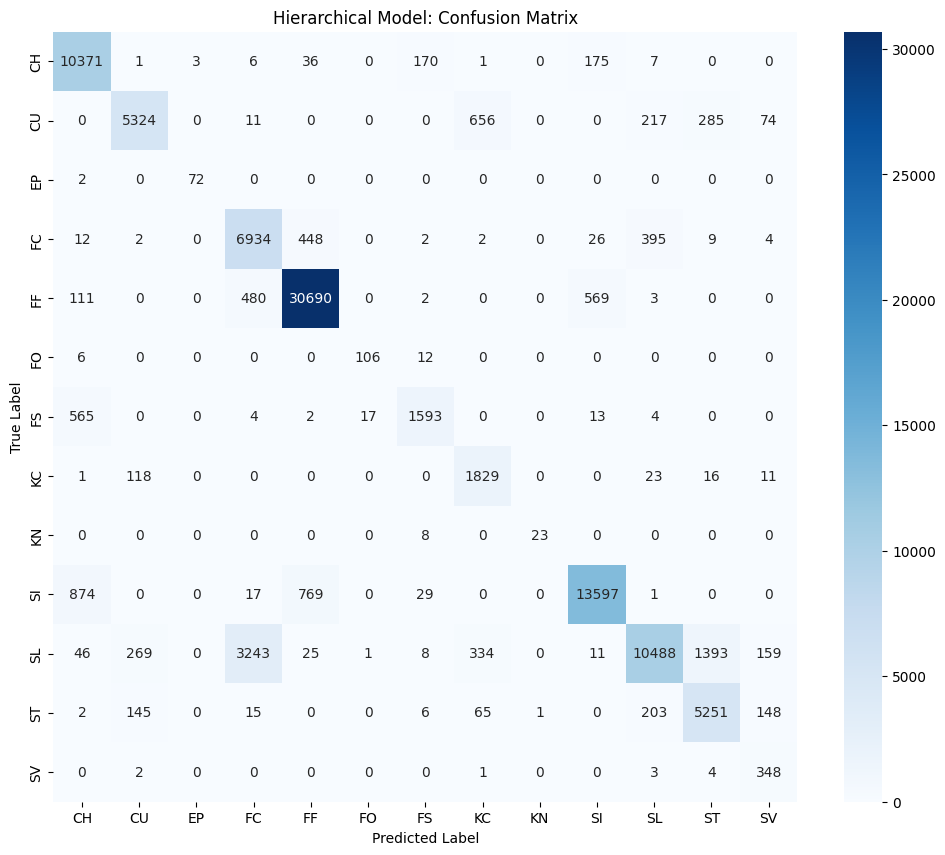


=== SI vs FF Check (Hierarchical) ===


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         0
          FC       0.00      0.00      0.00         0
          FF       0.98      0.96      0.97     31855
          FS       0.00      0.00      0.00         0
          SI       0.96      0.89      0.92     15287
          SL       0.00      0.00      0.00         0

    accuracy                           0.94     47142
   macro avg       0.32      0.31      0.32     47142
weighted avg       0.97      0.94      0.95     47142


=== FC vs SL Check (Hierarchical) ===
              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         0
          CU       0.00      0.00      0.00         0
          FC       0.68      0.89      0.77      7834
          FF       0.00      0.00      0.00         0
          FO       0.00      0.00      0.00         0
          FS       0.00      0.00      0.00         0
          KC       0.00      0.00      

In [8]:
# === Evaluation & Confusion Matrix ===

print(classification_report(valid_df_res['true_pitch_type'], valid_df_res['final_pred']))

# Confusion Matrix Heatmap
cm = confusion_matrix(valid_df_res['true_pitch_type'], valid_df_res['final_pred'])
labels = sorted(valid_df_res['true_pitch_type'].unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Hierarchical Model: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SI/FF Breakdown
print("\n=== SI vs FF Check (Hierarchical) ===")
si_ff_subset = valid_df_res[valid_df_res['true_pitch_type'].isin(['SI', 'FF'])]
print(classification_report(si_ff_subset['true_pitch_type'], si_ff_subset['final_pred']))

# FC/SL Breakdown
print("\n=== FC vs SL Check (Hierarchical) ===")
fc_sl_subset = valid_df_res[valid_df_res['true_pitch_type'].isin(['FC', 'SL'])]
print(classification_report(fc_sl_subset['true_pitch_type'], fc_sl_subset['final_pred']))
